## Setup Library

Sebelum mulai, alangkah baiknya mempersiapkan variable dan teman-temannya agar mudah untuk troubleshooting.

In [18]:
## Import dependencies
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as signal

In [19]:
## Create FaceLandmarker Object

## Define the models
base_options = python.BaseOptions(model_asset_path="Mediapipe-Models/face_landmarker.task")
VisionRunningMode = mp.tasks.vision.RunningMode
options = vision.FaceLandmarkerOptions(
    base_options=base_options,
    num_faces=1,
    running_mode = VisionRunningMode.IMAGE,
)
landmarker = vision.FaceLandmarker.create_from_options(options)   


In [20]:
# ## Create FaceDetector Object

# ## Define the models
# base_model="Mediapipe-Models/blaze_face_short_range.tflite"
# base_options = python.BaseOptions(model_asset_path=base_model)

# ## Mediapipe configuration options
# FaceDetectorOptions = vision.FaceDetectorOptions
# VisionRunningMode = vision.RunningMode
# options = FaceDetectorOptions(
#     base_options=base_options,
#     running_mode = VisionRunningMode.IMAGE,
# )
# face_detector = vision.FaceDetector.create_from_options(options)


In [21]:
def extract_rgb_from_rect(rect, image):
    x_min, y_min, x_max, y_max = rect
    roi = image[y_min:y_max, x_min:x_max]
    return roi

def get_cheek_rois(landmarks, image_shape):
    h, w, _ = image_shape
    left_cheek_indices = [111, 121, 50, 142]
    right_cheek_indices = [350, 340, 355, 280]

    left_cheek_points = [(int(landmarks[idx].x * w), int(landmarks[idx].y * h)) for idx in left_cheek_indices]
    right_cheek_points = [(int(landmarks[idx].x * w), int(landmarks[idx].y * h)) for idx in right_cheek_indices]

    left_cheek_rect = (
        min([pt[0] for pt in left_cheek_points]), min([pt[1] for pt in left_cheek_points]),
        max([pt[0] for pt in left_cheek_points]), max([pt[1] for pt in left_cheek_points])
    )
    # print("Left Cheek Rect:", left_cheek_rect)
    right_cheek_rect = (
        min([pt[0] for pt in right_cheek_points]), min([pt[1] for pt in right_cheek_points]),
        max([pt[0] for pt in right_cheek_points]), max([pt[1] for pt in right_cheek_points])
    )
    # print("Right Cheek Rect:", right_cheek_rect)

    return left_cheek_rect, right_cheek_rect


## POS (Plane-Orthogonal to Skin)
Metode rPPG untuk mengambil sinyal denyut dari tubuh secara remote dengan menganalisis perubahan warna kulit, sederhananya mengambil warna yang dipancarkan kulit lalu di ubah menjadi sinyal fisiologis. 

Referensi.
- [Ref. Paper](https://pure.tue.nl/ws/files/31563684/TBME_00467_2016_R1_preprint.pdf)



In [22]:
## Core method POS 
def POS(signal, **kargs):
    """
    POS method on CPU using Numpy.

    The dictionary parameters are: {'fps':float}.

    Wang, W., den Brinker, A. C., Stuijk, S., & de Haan, G. (2016). Algorithmic principles of remote PPG. IEEE Transactions on Biomedical Engineering, 64(7), 1479-1491. 
    """
    """
    eps: A small constant (10^-9) used to prevent division by zero in normalization steps.
    X: The input signal, which is a 3D array where:
    e: Number of estimators or regions in the frame (like different parts of the face).
    c: Color channels (3 for RGB).
    f: Number of frames.
    w: Window length, determined by the camera's frame rate (fps). For example, at 20 fps, w would be 32 (which corresponds to about 1.6 seconds of video).
    """
    eps = 10**-9
    X = signal
    e, c, f = X.shape # Number of estimators, color channels, and frames
    w = int(1.6 * kargs['fps']) # Window length in frames

    """
    P: A fixed 2x3 matrix used for the projection step. It defines how to transform the color channels (RGB) into a new space.
    Q: This is a stack of the matrix P repeated e times, where each P corresponds to an estimator (region of interest) in the video.
    """
    P = np.array([[0, 1, -1], [-2, 1, 1]])
    Q = np.stack([P for _ in range(e)], axis = 0)

    """
    H: A matrix to store the estimated heart rate signal over time for each estimator.
    n: The current frame in the sliding window.
    m: The start index of the sliding window (calculating which frames are part of the current window).
    """
    H = np.zeros((e, f))
    for n in np.arange(w, f):
        # Start index of sliding window 
        m = n - w + 1

        """
        Temporal Normalization (Equation 5 from the paper): This step ensures that the signal is invariant to global lighting changes and other noise factors.
        """
        Cn = X[:, :, m:(n+1)]
        M = 1.0 / (np.mean(Cn, axis = 2) + eps)
        M = np.expand_dims(M, axis=2) # shape [e, c, w]
        Cn = np.multiply(Cn, M)

        """
        Projection (Equation 6 from the paper): This step transforms the RGB values into a space where the signal from blood flow (heart rate) is more distinct.
        """
        S = np.dot(Q, Cn)
        S = S[0, :, :, :]
        S = np.swapaxes(S, 0, 1) 

        """
        Tuning (Equation 7 from the paper): This step adjusts the projected components to make the heart rate signal clearer.
        """
        S1 = S[:, 0, :]
        S2 = S[:, 1, :]
        alpha = np.std(S1, axis=1) / (eps + np.std(S2, axis=1))
        alpha - np.expand_dims(alpha, axis=1)
        Hn = np.add(S1, alpha * S2)
        Hnm = Hn - np.expand_dims(np.mean(Hn, axis=1), axis=1)

        """
        Overlap-Adding (Equation 8 from the paper): This step combines the processed signals from each frame to form the final output heart rate signal.
        """
        H[:, m:(n + 1)] = np.add(H[:, m:(n + 1)], Hnm)  # Add the tuned signal to the output matrix

    return H


In [23]:
## Some variables, containers, constants and buffer
r_signal, g_signal, b_signal = [], [], [] ## For storing RGB value from the skin
fps = 30 ## Frame rate of the camera
time_window = 120 # Time window in seconds
frame_buffer_limit = time_window * fps ## Number of frames to be processed, since toby-rgb is 60 seconds
frame_buffer = [] ## Buffer for storing frames
margin_x = 10  # Adjust horizontally
scaling_factor = 0.8 # Scaling factor for the bounding box


In [24]:
# ## Some variables, containers, constants and buffer
# r_signal, g_signal, b_signal = [], [], [] ## For storing RGB value from the skin
# fps = 35 ## Frame rate of the camera
# time_window = 60 # Time window in seconds
# frame_buffer_limit = time_window * fps ## Number of frames to be processed, since toby-rgb is 60 seconds
# frame_buffer = [] ## Buffer for storing frames
# margin_x = 10  # Adjust horizontally
# scaling_factor = 0.8 # Scaling factor for the bounding box


### Main Method 📖

Tahapan ini cukup penting dalam proses pengubahan sinyal RGB kulit menjadi sinyal fisiologis tubuh. 

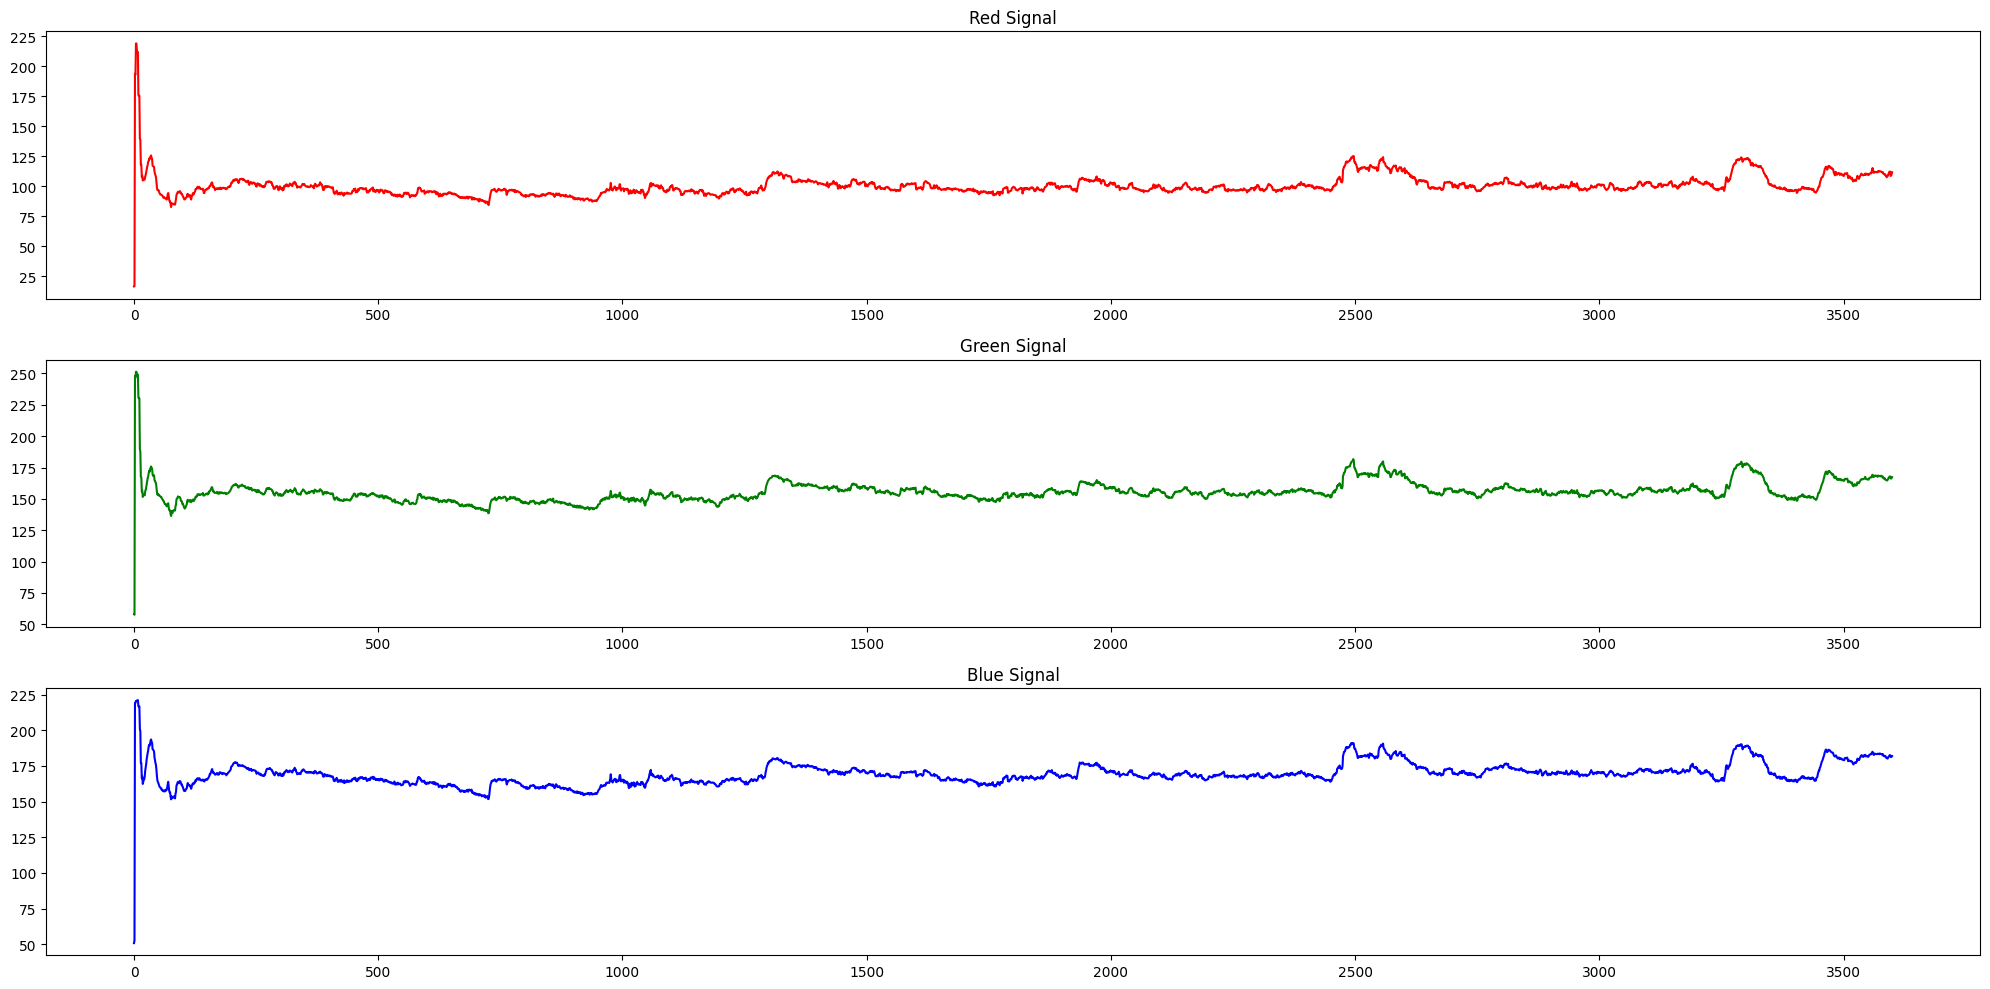

In [25]:
try:
    ## Load the Video
    # file_path = os.path.join("media/toby-rgb.mp4") ## Path to the video file
    
    ## Put 0 to use the camera, or use the video file path for analyzing a video
    cap = cv2.VideoCapture(1) 

    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()

    combined_r_signal = []
    combined_g_signal = []
    combined_b_signal = []

    ## Untuk mendapatkan 60 detik video.
    while len(frame_buffer) < frame_buffer_limit:

        ## Read the frame from the camera
        ret, frame = cap.read() 
        if not ret:
            print("Error: Could not read frame.")
            break

        ## Adding the frame_buffer to the list
        frame_buffer.append(frame)

        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        left_r_signal, left_g_signal, left_b_signal = [], [], []
        right_r_signal, right_g_signal, right_b_signal = [], [], []

        mp_image = mp.Image(
            image_format=mp.ImageFormat.SRGB,
            data=image_rgb
        )

        # Get the landkmarks
        result = landmarker.detect(mp_image)

        if not result.face_landmarks:
            print("No face landmarks detected")

        if result.face_landmarks:
            for face_landmark in result.face_landmarks:
                # Get cheek ROIs
                left_cheek_rect, right_cheek_rect = get_cheek_rois(face_landmark, frame.shape)

                # Draw both cheek ROIs with rectangles
                cv2.rectangle(frame, (left_cheek_rect[0], left_cheek_rect[1]), (left_cheek_rect[2], left_cheek_rect[3]), (0, 255, 0), 2)
                cv2.rectangle(frame, (right_cheek_rect[0], right_cheek_rect[1]), (right_cheek_rect[2], right_cheek_rect[3]), (0, 255, 0), 2)

                # Extract the left and right cheek ROIs
                left_cheek_roi = extract_rgb_from_rect(left_cheek_rect, frame)
                right_cheek_roi = extract_rgb_from_rect(right_cheek_rect, frame)

                # Calculate mean pixel values for the RGB channels
                left_cheek_rgb = cv2.mean(left_cheek_roi)[:3]
                right_cheek_rgb = cv2.mean(right_cheek_roi)[:3]

                # Append the RGB values to the respective lists
                left_r_signal.append(left_cheek_rgb[0])
                left_g_signal.append(left_cheek_rgb[1])
                left_b_signal.append(left_cheek_rgb[2])

                right_r_signal.append(right_cheek_rgb[0])
                right_g_signal.append(right_cheek_rgb[1])
                right_b_signal.append(right_cheek_rgb[2])

                # Combine and average the RGB values from both cheeks
                combined_r = (left_cheek_rgb[0] + right_cheek_rgb[0]) / 2
                combined_g = (left_cheek_rgb[1] + right_cheek_rgb[1]) / 2
                combined_b = (left_cheek_rgb[2] + right_cheek_rgb[2]) / 2

                # Append the combined RGB values to the respective lists
                r_signal.append(combined_r)
                g_signal.append(combined_g)
                b_signal.append(combined_b)

        # Show the frame
        cv2.imshow("frame", frame) 

        # Check if 'q' is pressed or the window is closed
        if cv2.waitKey(1) & 0xFF == ord('q') or cv2.getWindowProperty("frame", cv2.WND_PROP_VISIBLE) < 1:
            break

except Exception as e:
    print(f"An error occurred: {e}")
    cap.release()
    cv2.destroyAllWindows()

finally:
    ## Release the camera and close all windows
    cap.release()
    cv2.destroyAllWindows()

    ax, fig = plt.subplots(3, 1, figsize=(20, 10))
    fig[0].plot(r_signal, color='red')
    fig[0].set_title('Red Signal')
    fig[1].plot(g_signal, color='green')
    fig[1].set_title('Green Signal')
    fig[2].plot(b_signal, color='blue')
    fig[2].set_title('Blue Signal')
    plt.tight_layout()
    plt.show()


In [26]:
# try:    
#     ## Put 0 to use the camera, or use the video file path for analyzing a video
#     cap = cv2.VideoCapture(1) 

#     if not cap.isOpened():
#         print("Error: Could not open video.")
#         exit()

#     ## Untuk mendapatkan 60 detik video.
#     while len(frame_buffer) < frame_buffer_limit:

#         ## Read the frame from the camera
#         ret, frame = cap.read() 
#         if not ret:
#             print("Error: Could not read frame.")
#             break

#         ## Adding the frame_buffer to the list
#         frame_buffer.append(frame)


#         ## Convert the frame to RGB
#         ## Karena default dari OpenCV adalah BGR, kita perlu mengkonversi ke RGB
#         rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

#         ## Seting up the Mediapipe Image
#         mp_image = mp.Image(
#             image_format=mp.ImageFormat.SRGB,
#             data=rgb_frame
#         )

#         ## Process the frame using the face detector
#         result = face_detector.detect(mp_image)

#         """
#         Where the magic happens:

#         Proses ini melakukan deteksi wajah pada frame video untuk mendapatkan bounding box wajah.
#         Kemudian, bounding box ini digunakan untuk mendapatkan ROI (Region of Interest) dari wajah, yang kemudian digunakan 
#         untuk menghitung nilai rata-rata RGB dari area tersebut. 

#         Nilai rata-rata RGB ini disimpan dalam list r_signal, g_signal, dan b_signal untuk analisis lebih lanjut.
#         """
#         if result.detections:
#             for detection in result.detections:

#                 ## Get the Bounding box
#                 bboxC = detection.bounding_box
#                 x, y, w, h = bboxC.origin_x, bboxC.origin_y, bboxC.width, bboxC.height

#                 ## Setup tipis tipis biar boxnya pas di tengah wajah
#                 new_x = int(x + margin_x)
#                 new_w = int(w * scaling_factor)
#                 new_h = int(h * scaling_factor)

#                 ## Get the ROI
#                 face_roi = rgb_frame[y:y+new_h, new_x:new_x+new_w]
            
#                 ## Draw the bounding box on the frame
#                 cv2.rectangle(frame, (int(x), int(y)), (int(x + new_w), int(y + new_h)), (0, 255, 0), 2)

#                 ## Calculate the Mean RGB values of the face ROI
#                 mean_rgb = cv2.mean(face_roi)[:3]
                
#                 # Append the combined RGB values to the respective lists
#                 r_signal.append(mean_rgb[0])
#                 g_signal.append(mean_rgb[1])
#                 b_signal.append(mean_rgb[2])

#         # Show the frame
#         cv2.imshow("frame", frame) 

#         # Check if 'q' is pressed or the window is closed
#         if cv2.waitKey(1) & 0xFF == ord('q') or cv2.getWindowProperty("frame", cv2.WND_PROP_VISIBLE) < 1:
#             break

# except Exception as e:
#     print(f"An error occurred: {e}")
#     cap.release()
#     cv2.destroyAllWindows()

# finally:
#     ## Release the camera and close all windows
#     cap.release()
#     cv2.destroyAllWindows()

#     ax, fig = plt.subplots(3, 1, figsize=(20, 10))
#     fig[0].plot(r_signal, color='red')
#     fig[0].set_title('Red Signal')
#     fig[1].plot(g_signal, color='green')
#     fig[1].set_title('Green Signal')
#     fig[2].plot(b_signal, color='blue')
#     fig[2].set_title('Blue Signal')
#     plt.tight_layout()
#     plt.show()


### Post-Processing rPPG signals
Sinyal yang diperoleh masih cukup raw (mentah), masih belum bisa dilakukan analisis lebih lanjut tanpa post-processing. 

Pada tahapan ini akan dilakukan post-processing untuk melakukan filtering sinyal dan menentukan peak dari sinyal yang merupkan tanda dari detak jantung.
\
Tahapan pertama yakni merubah sinyal RGB menjadi rPPG

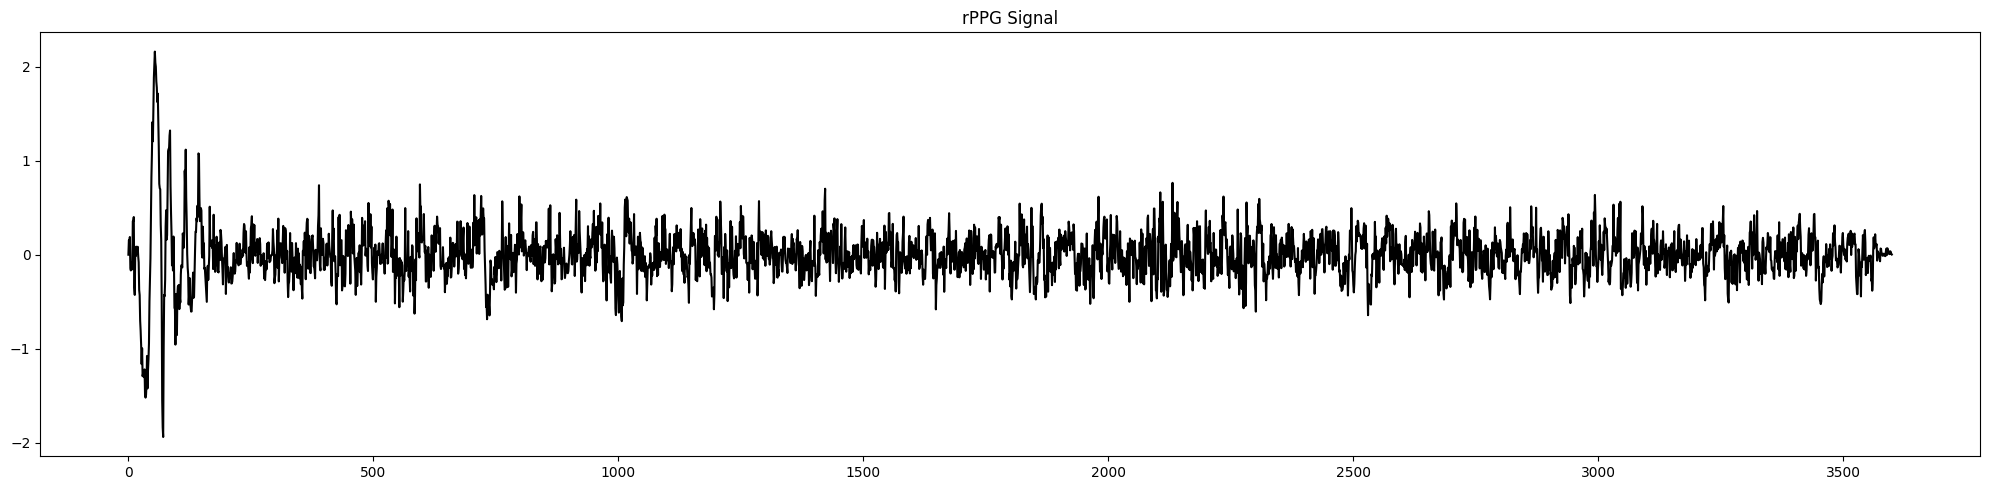

In [27]:
# Menghitung rPPG menggunakan Metode POS
rgb_signals = np.array([r_signal, g_signal, b_signal])
rgb_signals = rgb_signals.reshape(1, 3, -1)
rppg_signal = POS(rgb_signals, fps=30)
rppg_signal = rppg_signal.reshape(-1)

# 6.1 Menampilkan grafik Sinyal rPPG
plt.figure(figsize=(20, 5))
plt.plot(rppg_signal, color='black')
plt.title('rPPG Signal')
plt.tight_layout()
plt.show()

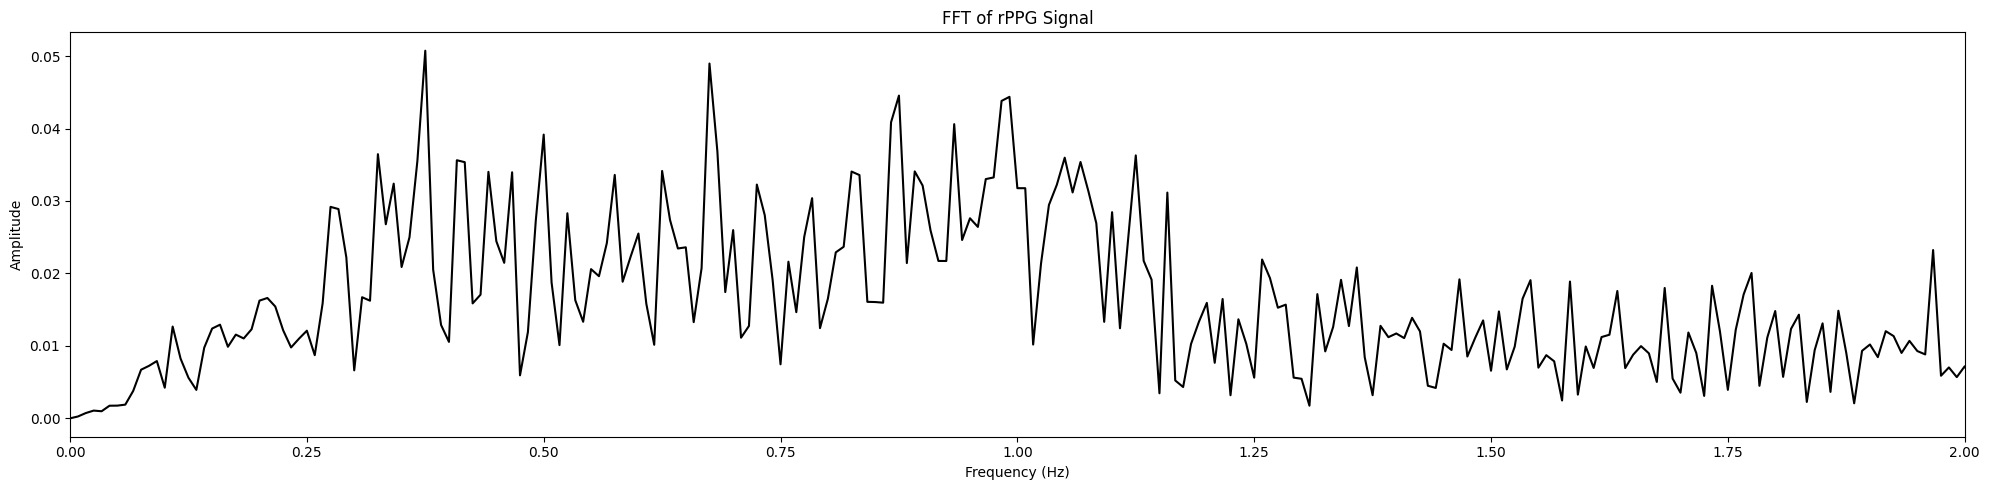

In [28]:
### Look for the Frequency FFT of the signal
from scipy.fft import fft, fftfreq

# 6.2 Menghitung FFT dari sinyal rPPG
N = len(rppg_signal)
T = 1.0 / 30.0  # Asumsi frame rate 30 fps
xf = fftfreq(N, T)[:N//2]
yf = fft(rppg_signal)
# 6.3 Menampilkan grafik FFT
plt.figure(figsize=(20, 5))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]), color='black')
plt.title('FFT of rPPG Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 2.0)  # Batasi sumbu x untuk fokus pada frekuensi rendah
plt.tight_layout()
plt.show()

## Simple basic filtering

In [29]:
# from scipy import signal

# # Simple bandpass filtering for the rPPG signal

# # Define filter parameters
# fs = 30  # Sampling frequency in Hz (based on FPS)
# lowcut = 0.7  # Lower cutoff frequency in Hz (for heart rate ~42 BPM)
# highcut = 3.5  # Higher cutoff frequency in Hz (for heart rate ~180 BPM)
# order = 4  # Filter order

# # Create a butterworth bandpass filter
# b, a = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)

# # Apply the filter to the rPPG signal
# filtered_rppg_basic = signal.filtfilt(b, a, rppg_signal)

# # Plot the original and filtered signals
# plt.figure(figsize=(20, 10))

# plt.subplot(2, 1, 1)
# plt.plot(rppg_signal, color='black')
# plt.title('Original rPPG Signal')
# plt.xlabel('Samples')
# plt.ylabel('Amplitude')

# plt.subplot(2, 1, 2)
# plt.plot(filtered_rppg_basic, color='blue')
# plt.title('Basic Filtered rPPG Signal')
# plt.xlabel('Samples')
# plt.ylabel('Amplitude')

# plt.tight_layout()
# plt.show()

# # Find peaks in the filtered signal
# peaks, _ = signal.find_peaks(filtered_rppg_basic, distance=30)  # Minimum distance between peaks

# # Calculate heart rate (beats per minute)
# heart_rate = 60 * len(peaks) / (len(filtered_rppg_basic) / fs)
# print(f"Estimated Heart Rate: {heart_rate:.2f} BPM")

# # Plot the filtered signal with detected peaks
# plt.figure(figsize=(20, 5))
# plt.plot(filtered_rppg_basic, color='blue')
# plt.plot(peaks, filtered_rppg_basic[peaks], "x", color='red', markersize=10, label='Peaks')
# plt.title(f'Filtered rPPG Signal with Peaks (Heart Rate: {heart_rate:.2f} BPM)')
# plt.legend()
# plt.tight_layout()
# plt.show()

In [30]:
# # Calculate the FFT of the basic filtered rPPG signal
# N = len(filtered_rppg_basic)
# T = 1.0 / 30.0  # Assuming 30 fps
# xf = fftfreq(N, T)[:N//2]
# yf = fft(filtered_rppg_basic)

# # Plot the FFT of the filtered signal
# plt.figure(figsize=(20, 5))
# plt.plot(xf, 2.0/N * np.abs(yf[:N//2]), color='blue')
# plt.title('FFT of Basic Filtered rPPG Signal')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude')
# plt.xlim(0, 2.0)  # Limit x-axis to focus on lower frequencies
# plt.axvline(x=lowcut, color='red', linestyle='--', label=f'Lowcut ({lowcut} Hz)')
# plt.axvline(x=highcut, color='green', linestyle='--', label=f'Highcut ({highcut} Hz)')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Find the dominant frequency in the heart rate range
# heart_rate_range = (xf >= 0.7) & (xf <= 3.0)  # Frequency range corresponding to 42-180 BPM
# dominant_freq = xf[heart_rate_range][np.argmax(np.abs(yf[:N//2])[heart_rate_range])]
# hr_from_fft = dominant_freq * 60  # Convert frequency to BPM
# print(f"Heart Rate from FFT: {hr_from_fft:.2f} BPM")

## Post-Processing dan Analysis 
Selanjutnya adalah tahapan filtering dan menentukan analisis menentukan peak / puncak dari sinyal

In [31]:
## Create a dataFrame for storing the HRV Metrics
hrv_metrics = {
    'MeanNN': [],
    'SDNN': [],
    'RMSSD': [],
    'pNN50': [],
    'LF': [],
    'HF': [],
    'LF_HF': [],
    'PR' : [],
}

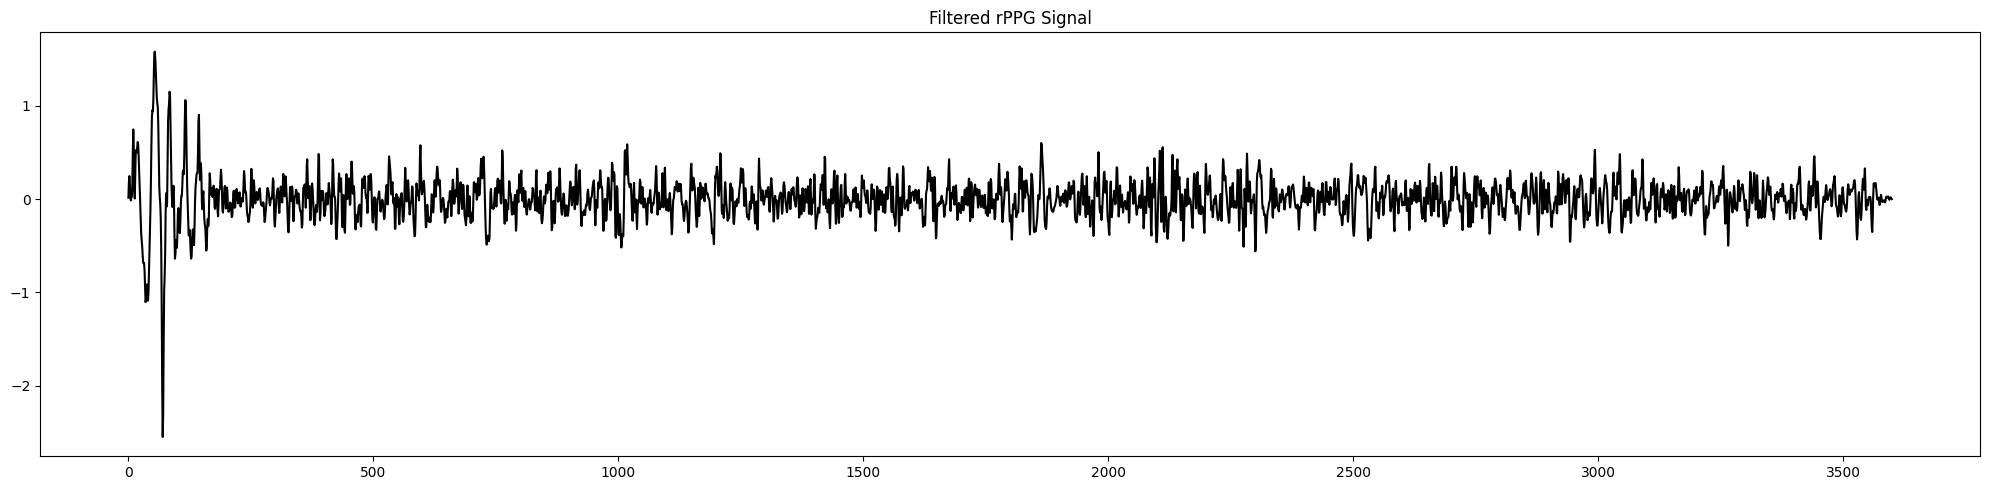

HRV Metrics:
        MeanNN        SDNN       RMSSD     pNN50        LF        HF  \
0  1018.103448  585.664365  843.783749  91.37931  0.058855  0.041272   

      LF_HF         PR  
0  1.426039  58.933108  


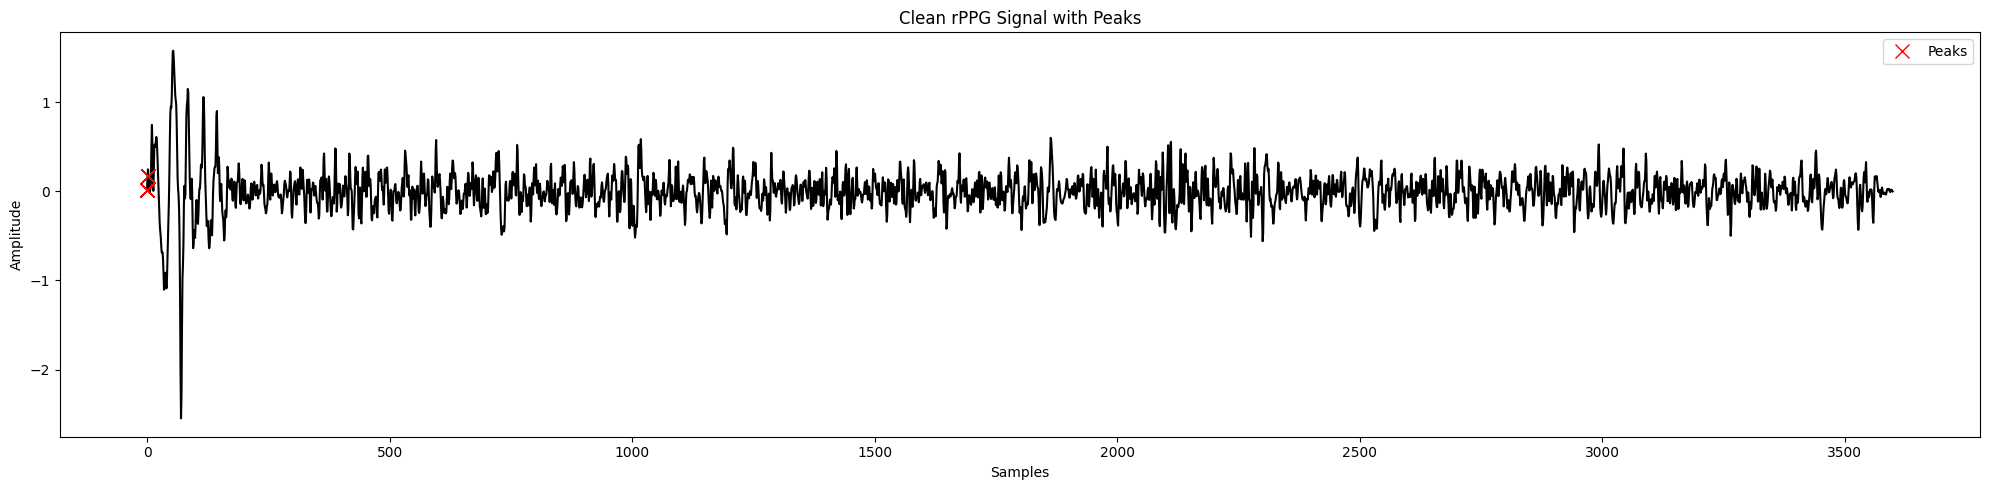

In [32]:
# # Post Processing
# # fs = 30; lowcut = 0.5; highcut = 3.7; order = 4
# # b, a = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
# # filtered_rppg = signal.filtfilt(b, a, rppg_signal)

# ## Find the peaks with the find_peaks function
# peaks, _ = signal.find_peaks(filtered_rppg)
# print(f"Number of peaks found: {len(peaks)} BPM: {len(peaks) * 60 / (len(filtered_rppg) / fs)}")

# ## Plot the PPG signal with the peaks
# plt.figure(figsize=(20, 5))
# plt.plot(filtered_rppg, color='black')
# plt.plot(peaks, filtered_rppg[peaks], "x", color='red', label='Peaks')
# plt.title('PPG Signal with Peaks')
# plt.tight_layout()

## Post Processing with neurokit2
import neurokit2 as nk

fs=30
## Process the rPPG signal using NeuroKit2
signals, _ = nk.ppg_process(rppg_signal, sampling_rate=fs)
peaks, _ = nk.ppg_peaks(signals['PPG_Clean'], sampling_rate=fs)

## Plot the filtered rPPG signal
plt.figure(figsize=(20, 5))
plt.plot(signals['PPG_Clean'], color='black')
plt.title('Filtered rPPG Signal')
plt.tight_layout()
plt.show()

# Store the PR into the hrv_metrics
hrv_metrics['PR'].append(signals['PPG_Rate'][0].item())

# Calculate HRV metrics
## Time domain metrics
hrv_time = nk.hrv_time(peaks, sampling_rate=fs)
hrv_metrics['MeanNN'].append(hrv_time['HRV_MeanNN'].item())
hrv_metrics['SDNN'].append(hrv_time['HRV_SDNN'].item())
hrv_metrics['RMSSD'].append(hrv_time['HRV_RMSSD'].item())
hrv_metrics['pNN50'].append(hrv_time['HRV_pNN50'].item())

# Frequency domain metrics
hrv_freq = nk.hrv_frequency(peaks, sampling_rate=fs)
hrv_metrics['LF'].append(hrv_freq['HRV_LF'].item())
hrv_metrics['HF'].append(hrv_freq['HRV_HF'].item())
hrv_metrics['LF_HF'].append(hrv_freq['HRV_LFHF'].item())

## Store the HRV Metrics into a DataFrame
import pandas as pd
hrv_df = pd.DataFrame(hrv_metrics)

# Display the HRV Metrics
print("HRV Metrics:")
print(hrv_df)

# Save the HRV Metrics to a CSV file
hrv_df.to_csv('hrv_metrics_subject1-breath-random.csv', index=False)

## Plot the peaks on the clean rPPG signals
plt.figure(figsize=(20, 5))
plt.plot(signals['PPG_Clean'], color='black')
plt.plot(peaks['PPG_Peaks'], signals['PPG_Clean'][peaks['PPG_Peaks']], "x", color='red', markersize=10, label='Peaks')
plt.title('Clean rPPG Signal with Peaks')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()
plt.tight_layout()
plt.show()



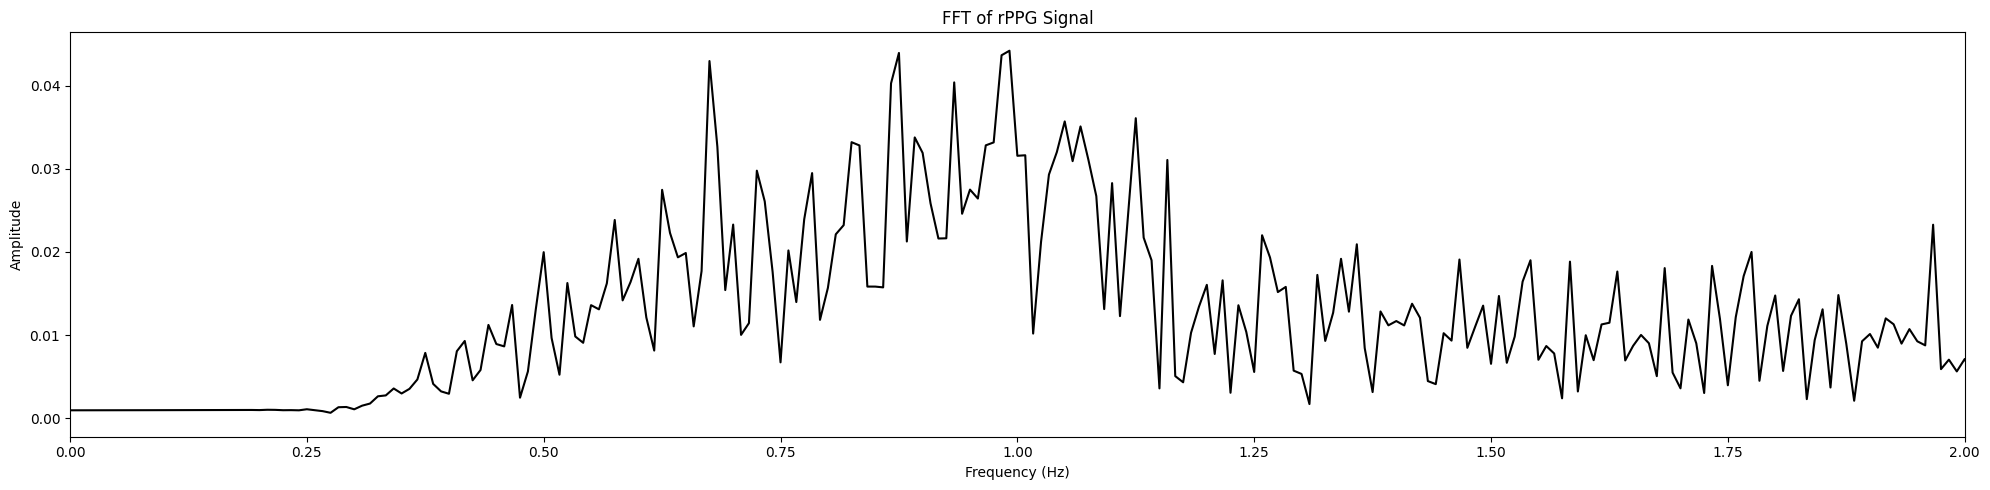

In [33]:
### Look for the Frequency FFT of the signal
from scipy.fft import fft, fftfreq

# 6.2 Menghitung FFT dari sinyal rPPG
N = len(signals['PPG_Clean'])
T = 1.0 / 30.0  # Asumsi frame rate 30 fps
xf = fftfreq(N, T)[:N//2]
yf = fft(signals['PPG_Clean'])
# 6.3 Menampilkan grafik FFT
plt.figure(figsize=(20, 5))
plt.plot(xf, 2.0/N * np.abs(yf[:N//2]), color='black')
plt.title('FFT of rPPG Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim(0, 2.0)  # Batasi sumbu x untuk fokus pada frekuensi rendah
plt.tight_layout()
plt.show()

In [34]:
# # Memfilter Sinyal rPPG
# fs = 35; lowcut = 0.9; highcut = 2.4; order = 3
# b, a = signal.butter(order, [lowcut, highcut], btype='band', fs=fs)
# filtered_rppg = signal.filtfilt(b, a, rppg_signal)

# fig, ax = plt.subplots(2, 1, figsize=(20, 6))
# ax[0].plot(rppg_signal, color='black')
# ax[0].set_title('rPPG Signal - Before Filtering')
# ax[1].plot(filtered_rppg, color='black')
# ax[1].set_title('rPPG Signal - After Filtering')
# plt.tight_layout()
# plt.show()

# # Mencari puncak sinyal
# peaks, _ = signal.find_peaks(
#     x=filtered_rppg,
# )

# # Menghitung heart rate
# heart_rate = 60 * len(peaks) / (len(filtered_rppg) / fs)

# # Menampilkan grafik puncak sinyal
# plt.figure(figsize=(20, 5))
# plt.plot(filtered_rppg, color='black')
# plt.plot(peaks, filtered_rppg[peaks], 'x', color='red')
# plt.title(f'Heart Rate: {heart_rate:.2f}')
# plt.tight_layout()
# plt.show()